<a href="https://colab.research.google.com/github/Aayush360/Fast_AI/blob/master/fastai_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision import *

In [ ]:
folder='abstract'
file='abstract.csv'

In [ ]:
folder='potrait'
file='potrait.csv'

In [ ]:
folder='landscape'
file='landscape.csv'

In [ ]:
path = Path('data/painting')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()


[PosixPath('data/painting/potrait'),
 PosixPath('data/painting/landscape'),
 PosixPath('data/painting/abstract')]

In [ ]:
classes = ['abstract','landscape','potrait']


In [ ]:
download_images(path/file, dest, max_pics=200)


In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

abstract


landscape


potrait


In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [ ]:
data.classes


['abstract', 'landscape', 'potrait']

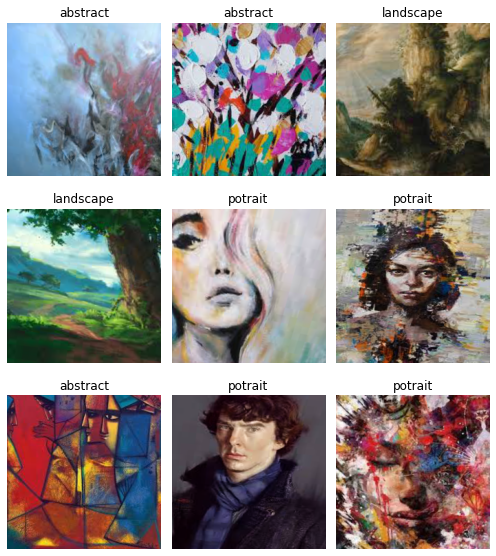

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['abstract', 'landscape', 'potrait'], 3, 480, 120)

In [ ]:
# Training the model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,time
0,1.552908,0.461350,0.150000,00:08
1,0.969962,0.632385,0.141667,00:06
2,0.722354,0.572553,0.100000,00:06
3,0.592843,0.529405,0.091667,00:06


In [ ]:
learn.save('stage-1')


In [ ]:
learn.unfreeze()
#All weights from frozen layers of the model now can get updated from their pre-trained 
#state according to loss function.


In [ ]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.lr_find(start_lr=1e-04, end_lr=3e-04)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


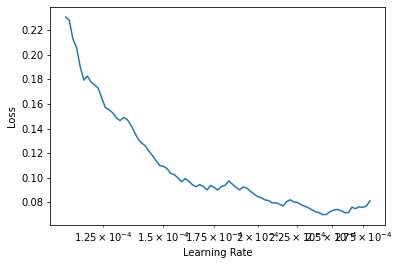

In [ ]:
learn.recorder.plot()


In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,3e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.213831,0.409424,0.066667,00:07
1,0.174180,0.356321,0.108333,00:07


In [ ]:
learn.save('stage-2')


In [ ]:
#Interpretation

In [ ]:
learn.load('stage-2');


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


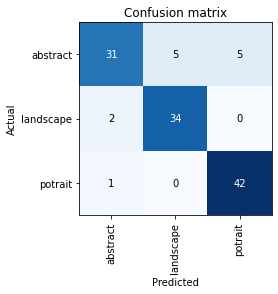

In [ ]:
interp.plot_confusion_matrix()


In [ ]:
#Cleaning up

In [ ]:
from fastai.widgets import *


In [ ]:

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

Notice that the widget will not delete images directly from disk but it will create a new csv file cleaned.csv from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)


In [ ]:
#find duplicates in your dataset and delete them

ds, idxs = DatasetFormatter().from_similars(learn_cln)


Getting activations...


Computing similarities...


In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)


Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [ ]:
#Putting the model to production

In [ ]:
learn.export()


In [ ]:
defaults.device = torch.device('cpu')


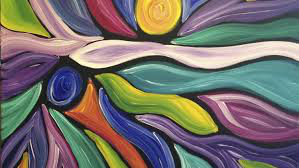

In [ ]:
img = open_image(path/'abstract'/'00000000.jpg')
img


In [ ]:
learn = load_learner(path)


In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj


'abstract'